In [2]:
from music21 import corpus, stream, note
import tensorflow as tf
import math
import functools
import numpy as np

In [3]:
# numbeer of voices
num_voices = 4

#number of output classes, i.e. half tone differences to melody
num_classes = 24

# duration of time tick in beats. 1=quarter, 0.25=16th 
time_tick = 0.25

In [4]:
def extractMelody(music):
    melody = []
    currentOffset = 0
    for n in music.parts[0].flat.notes:
        #print("%s: %s %s %s" % (n.pitch.midi, n.pitch, n.offset, n.duration.quarterLength))
        while (n.offset > currentOffset):
            # insert breaks
            melody.append([currentOffset, 0, 1])
            currentOffset += time_tick;
        noteTicks = math.floor(n.duration.quarterLength / time_tick)
        for ticks in range(0, noteTicks):
            if (ticks == 0):
                melody.append([currentOffset, n.pitch.midi, 1])
            else:
                melody.append([currentOffset, n.pitch.midi, 0])
            currentOffset += time_tick;
    return melody

In [5]:
# calculate difference between melody and voice in halftones. 1: same halftone, 2: one halftone below 
# Limit to num_classes. If the difference is greater, shift the voice by octaves.
def noteDifference(melody, voice):
    diff = melody - voice
    if diff < 0:  raise Exception("Error: voice above melody")
    while (diff > num_classes):
        diff -= 12
    return diff + 1

In [6]:
def extractVoices(melody, music):
    for partIndex in range(1, len(music.parts)):
        partNotes = music.parts[partIndex].flat.notes
        noteIndex = 0;
        maxNoteIndex = len(partNotes)
        
        for n in melody:
            #print(n)
            currentOffset = n[0]
            if (noteIndex < maxNoteIndex):
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset + voiceNote.duration.quarterLength <= currentOffset):
                    # skip to next note
                    noteIndex += 1
            if (noteIndex < maxNoteIndex):                
                voiceNote = partNotes[noteIndex]
                if (voiceNote.offset == currentOffset):
                    # new note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(1)
                elif (voiceNote.offset < currentOffset):
                    # continuing note
                    n.append(noteDifference(n[1], voiceNote.pitch.midi))
                    n.append(0)
                else:
                    # between notes or behind last note, fill with empty 
                    n.append(0)
                    n.append(1)

In [7]:
songs = []
streams = []
for name in corpus.chorales.Iterator(returnType='filename'):
    song = corpus.parse(name)
    key = song.analyze('key')
    highestTime = song.highestTime
    if len(song.parts) == 4 and song.parts[0].flat.getTimeSignatures()[0].numerator == 4 and key.mode == 'major' \
        and highestTime < 68:
        print('%s: %s, %s voices, duration: %s' % (name, key, len(song.parts), highestTime))
        song.transpose(song.analyze('key').sharps, inPlace = True)
        #song.show()
        try:
            notes = extractMelody(song)
            extractVoices(notes, song)
            songs.append(notes)
            streams.append(song)
            #song.show()
            #song.show('midi')
            
        except Exception as E:
            print(E)
            print("Error: %s not expected format, ignored" % name)
    #print(notes)

bach/bwv86.6: E major, 4 voices, duration: 56.0
bach/bwv281: F major, 4 voices, duration: 32.0
bach/bwv248.12-2: G major, 4 voices, duration: 64.0
bach/bwv318: G major, 4 voices, duration: 52.0
bach/bwv415: D major, 4 voices, duration: 64.0
bach/bwv20.11: F major, 4 voices, duration: 64.0
bach/bwv308: B- major, 4 voices, duration: 56.0
bach/bwv386: A major, 4 voices, duration: 65.0
bach/bwv248.53-5: A major, 4 voices, duration: 48.0
bach/bwv385: A major, 4 voices, duration: 56.0
bach/bwv255: G major, 4 voices, duration: 32.0
bach/bwv67.7: A major, 4 voices, duration: 52.0
bach/bwv377: D major, 4 voices, duration: 48.0
'Chord' object has no attribute 'pitch'
Error: bach/bwv377 not expected format, ignored
bach/bwv244.37: F major, 4 voices, duration: 48.0
Error: voice above melody
Error: bach/bwv244.37 not expected format, ignored
bach/bwv429: A major, 4 voices, duration: 60.0
bach/bwv151.5: G major, 4 voices, duration: 40.0
bach/bwv133.6: D major, 4 voices, duration: 64.0
bach/bwv159.5:

In [8]:
print(len(streams))

98


In [11]:
def createStream(music, numVoices=4):
    sc = stream.Score()
    notes = []
    for v in range(0, numVoices):
        sc.insert(0, stream.Part())
        notes.append(None)

    melodyPitchIndex = 1
        
    for tick in music:
        for voice in range (0, numVoices):
            part = sc.parts[voice]
            pitchIndex = 1 + voice * 2
            attackIndex = 1 + voice * 2 + 1
            # extend note
            if notes[voice] != None and tick[attackIndex] == 0:
                notes[voice].quarterLength += time_tick
            
            if tick[attackIndex] == 1:
                if (tick[pitchIndex]) > 0:
                    #create new note
                    n = note.Note()
                    notes[voice] = n
                    n.offset = tick[0]
                    if (voice == 0):
                        #melody voice
                        n.pitch.midi = tick[pitchIndex]
                    else:
                        #other voices relative to melody
                        n.pitch.midi = tick[melodyPitchIndex] - tick[pitchIndex] + 1
                    n.quarterLength = time_tick
                    part.append(n)
                else:
                    n = note.Rest()
                    notes[voice] = n
                    n.offset = tick[0]
                    n.quarterLength = time_tick
                    part.append(n)
    return sc
    
                        

In [1]:
#print(songs[0])
sc = createStream(songs[0])
print(sc.analyze('key'))
#sc.transpose(-sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


NameError: name 'createStream' is not defined

In [46]:
print(songs[0][0:20])
X=[]
Y=[]
for sg in songs[0:]:
    x=[]
    y=[]
    print(sg)
    for tick in sg:
        print(tick)
        x.append([tick[1], tick[2]])
        y.append(tick[3])
    X.append(x)
    Y.append(y)
print(X)
print(Y)

[[0, 68, 1, 6, 1, 9, 1, 25, 1], [0.25, 68, 0, 6, 0, 9, 0, 25, 0], [0.5, 68, 0, 6, 0, 9, 0, 25, 0], [0.75, 68, 0, 6, 0, 9, 0, 25, 0], [1.0, 68, 1, 6, 1, 9, 1, 13, 1], [1.25, 68, 0, 6, 0, 9, 0, 13, 0], [1.5, 68, 0, 6, 0, 9, 0, 13, 0], [1.75, 68, 0, 6, 0, 9, 0, 13, 0], [2.0, 68, 0, 4, 1, 8, 1, 16, 1], [2.25, 68, 0, 4, 0, 8, 0, 16, 0], [2.5, 68, 0, 4, 0, 9, 1, 16, 0], [2.75, 68, 0, 4, 0, 9, 0, 16, 0], [3.0, 75, 1, 13, 1, 18, 1, 21, 1], [3.25, 75, 0, 13, 0, 18, 0, 21, 0], [3.5, 75, 0, 13, 0, 18, 0, 21, 0], [3.75, 75, 0, 13, 0, 18, 0, 21, 0], [4.0, 72, 1, 10, 1, 17, 1, 17, 1], [4.25, 72, 0, 10, 0, 17, 0, 17, 0], [4.5, 72, 0, 10, 0, 17, 0, 17, 0], [4.75, 72, 0, 10, 0, 17, 0, 17, 0]]
[[0, 68, 1, 6, 1, 9, 1, 25, 1], [0.25, 68, 0, 6, 0, 9, 0, 25, 0], [0.5, 68, 0, 6, 0, 9, 0, 25, 0], [0.75, 68, 0, 6, 0, 9, 0, 25, 0], [1.0, 68, 1, 6, 1, 9, 1, 13, 1], [1.25, 68, 0, 6, 0, 9, 0, 13, 0], [1.5, 68, 0, 6, 0, 9, 0, 13, 0], [1.75, 68, 0, 6, 0, 9, 0, 13, 0], [2.0, 68, 0, 4, 1, 8, 1, 16, 1], [2.25, 68, 0, 4

[40.75, 70, 0, 6, 0, 15, 0, 22, 0]
[41.0, 72, 1, 10, 1, 17, 1, 17, 1]
[41.25, 72, 0, 10, 0, 17, 0, 17, 0]
[41.5, 72, 0, 10, 0, 17, 0, 19, 1]
[41.75, 72, 0, 10, 0, 17, 0, 19, 0]
[42.0, 73, 1, 9, 1, 18, 1, 21, 1]
[42.25, 73, 0, 9, 0, 18, 0, 21, 0]
[42.5, 73, 0, 9, 0, 18, 0, 23, 1]
[42.75, 73, 0, 9, 0, 18, 0, 23, 0]
[43.0, 75, 1, 10, 1, 20, 1, 15, 1]
[43.25, 75, 0, 10, 0, 20, 0, 15, 0]
[43.5, 75, 0, 10, 0, 20, 0, 16, 1]
[43.75, 75, 0, 10, 0, 20, 0, 16, 0]
[44.0, 77, 1, 13, 1, 22, 1, 17, 1]
[44.25, 77, 0, 13, 0, 22, 0, 17, 0]
[44.5, 77, 0, 11, 1, 22, 0, 15, 1]
[44.75, 77, 0, 11, 0, 22, 0, 15, 0]
[45.0, 72, 1, 5, 1, 17, 1, 20, 1]
[45.25, 72, 0, 5, 0, 17, 0, 20, 0]
[45.5, 72, 0, 6, 1, 15, 1, 20, 0]
[45.75, 72, 0, 6, 0, 15, 1, 20, 0]
[46.0, 74, 1, 7, 1, 17, 1, 17, 1]
[46.25, 74, 0, 7, 0, 17, 0, 17, 0]
[46.5, 74, 0, 5, 1, 17, 0, 17, 0]
[46.75, 74, 0, 5, 0, 17, 0, 17, 0]
[47.0, 75, 1, 9, 1, 18, 1, 25, 1]
[47.25, 75, 0, 9, 0, 18, 0, 25, 0]
[47.5, 75, 0, 9, 0, 18, 0, 25, 0]
[47.75, 75, 0, 9, 0, 1

In [ ]:
# https://gist.github.com/danijar/61f9226f7ea498abce36187ddaf51ed5
# Example for my blog post at:
# http://danijar.com/introduction-to-recurrent-networks-in-tensorflow/
import functools
import tensorflow as tf

# for state_is_tuple = True, currently does not work with undefined batch size
def get_state_variables(batch_size, cell):
    # For each layer, get the initial state and make a variable out of it
    # to enable updating its value.
    state_variables = []
    for state_c, state_h in cell.zero_state(batch_size, tf.float32):
        state_variables.append(tf.contrib.rnn.LSTMStateTuple(
            tf.Variable(state_c, trainable=False),
            tf.Variable(state_h, trainable=False)))
    # Return as a tuple, so that it can be fed to dynamic_rnn as an initial state
    return tuple(state_variables)


def get_state_update_op(state_variables, new_states):
    # Add an operation to update the train states with the last state tensors
    update_ops = []
    for state_variable, new_state in zip(state_variables, new_states):
        # Assign the new state to the state variables on this layer
        update_ops.extend([state_variable[0].assign(new_state[0]),
                           state_variable[1].assign(new_state[1])])
    # Return a tuple in order to combine all update_ops into a single operation.
    # The tuple's actual value should not be used.
    return tf.tuple(update_ops)

def lazy_property(function):
    attribute = '_' + function.__name__

    @property
    @functools.wraps(function)
    def wrapper(self):
        if not hasattr(self, attribute):
            setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return wrapper


class SequenceLabelling:

    def __init__(self, data, seq_length, target, dropout, num_hidden=200, num_layers=1):
        self.data = data
        self.target = target
        self.dropout = dropout
        self._num_hidden = num_hidden
        self._num_layers = num_layers
        self.seq_length = seq_length
        self.prediction
        self.error
        self.optimize
        #self.update_states

    @lazy_property
    def prediction(self):
        # Recurrent network.
        #cells = [tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)] * self._num_hidden
        cells = []
        for layer in range (0, self._num_layers):
            #cells.append(tf.nn.rnn_cell.BasicLSTMCell(self._num_hidden, state_is_tuple = True)) # or GRUCell)
            # a lot of fluctuation (8th/16th) in the results between different possible notes.
            # this might be reduced by the peep holes?
            cells.append(tf.nn.rnn_cell.LSTMCell(self._num_hidden, state_is_tuple = True, use_peepholes=True))
        
        network = tf.contrib.rnn.MultiRNNCell(cells, state_is_tuple = True)
        #network = tf.contrib.rnn.GRUCell(self._num_hidden)
        
        # if state_is_tuple = TRue, does not work with undefined btch size
        #self.states = get_state_variables(data.shape[0], network)
        #state = tf.Variable(network.zero_states(data.shape[0], tf.float32), trainable=False)
        
        output, new_states = tf.nn.dynamic_rnn(network, data, dtype=tf.float32, 
                                               sequence_length=self.seq_length) #, initial_state=states)
        
        # Add an operation to update the train states with the last state tensors.
        # if state_is_tuple = True, does not work with undefined btch size
        # self.update_states = get_state_update_op(states, new_states)
        # self.update_states = states.assign(new_states)
        
        # Softmax layer.
        max_length = int(self.target.get_shape()[1])
        num_classes = int(self.target.get_shape()[2])
        weight, bias = self._weight_and_bias(self._num_hidden, num_classes)
        # Flatten to apply same weights to all time steps.
        output = tf.reshape(output, [-1, self._num_hidden])
        prediction = tf.nn.softmax(tf.matmul(output, weight) + bias)
        prediction = tf.reshape(prediction, [-1, max_length, num_classes])
        return prediction

    @lazy_property
    def cost(self):
        masking = True
        if (masking):
            # Compute cross entropy for each frame.
            cross_entropy = target * tf.log(self.prediction)
            cross_entropy = -tf.reduce_sum(cross_entropy, 2)
            # mask out padding. ToDo: also rests have target value of 0
            mask = tf.sign(tf.reduce_max(tf.abs(target), 2))
            cross_entropy *= mask
            # Average over actual sequence lengths.
            cross_entropy = tf.reduce_sum(cross_entropy, 1)
            cross_entropy /= tf.reduce_sum(mask, 1)
            return tf.reduce_mean(cross_entropy)        
        else:
            # without masking:
            cross_entropy = -tf.reduce_sum(
            self.target * tf.log(self.prediction), [1, 2])
            cross_entropy = tf.reduce_mean(cross_entropy)
            return cross_entropy

    @lazy_property
    def optimize(self):
        learning_rate = 0.003
        optimizer = tf.train.RMSPropOptimizer(learning_rate)
        #optimizer = tf.train.MomentumOptimizer(learning_rate)
        return optimizer.minimize(self.cost)

    @lazy_property
    def error(self):
        mistakes = tf.not_equal(
            tf.argmax(self.target, 2), tf.argmax(self.prediction, 2))
        mistakes = tf.cast(mistakes, tf.float32)
        # mask out padding. ToDo: also rests have target value of 0
        mask = tf.sign(tf.reduce_max(tf.abs(target), 2))
        mistakes *= mask
        return tf.reduce_mean(tf.cast(mistakes, tf.float32))

    @staticmethod
    def _weight_and_bias(in_size, out_size):
        weight = tf.truncated_normal([in_size, out_size], stddev=0.01)
        bias = tf.constant(0.1, shape=[out_size])
        return tf.Variable(weight), tf.Variable(bias)


def read_dataset(songs):
    seq_length = []
    for song in songs: seq_length.append(len(song))
    max_seq_length = max(seq_length)

    print(max_seq_length)
    
    m = len(songs)    
    X=[]
    Y=[]
    for sg in songs:
        x=[]
        y=[]
        #print(sg)
        for tick in sg:
            #print(tick)
            x.append([tick[1], tick[2]])
            oneHot = np.zeros(num_classes)
            oneHot[tick[3]] = 1
            y.append(oneHot)
            #print("%s: %s -> %s" % (tick[0], tick[3], oneHot))
        # pad songs
        padding_length = max_seq_length - len(x)
        #print("padding:", padding_length)
        for i in range (0, padding_length):
            x.append([0, 0])
            y.append(np.zeros(num_classes))
        X.append(x)
        Y.append(y)   
    dataset = {'data': np.array(X), 'target' : np.array(Y), 'seq_length' : np.array(seq_length)}
    train, test = dataset, dataset#sets.Split(0.66)(dataset)
    return train, test


if __name__ == '__main__':
    tf.reset_default_graph()
    train, test = read_dataset(songs)
    print(train['data'].shape)
    print(train['target'].shape)
    _, length, input_size = train['data'].shape
    num_classes = train['target'].shape[2]
    data = tf.placeholder(tf.float32, [None, length, input_size])
    target = tf.placeholder(tf.float32, [None, length, num_classes])
    seq_length = tf.placeholder(tf.float32, [None])
    dropout = tf.placeholder(tf.float32)
    model = SequenceLabelling(data, seq_length, target, dropout, num_layers=3)
    sess = tf.Session()
    #sess.run(tf.initialize_all_variables())
    sess.run(tf.global_variables_initializer())

In [102]:
    for epoch in range(250):
        batchsize = 25
        for batchnum in range(4):
            batch_start = batchnum * batchsize
            batch_end = batchnum * batchsize + batchsize
            batch_end = min(90, batch_end)
            batch_data = train['data'][batch_start : batch_end]
            batch_target = train['target'][batch_start : batch_end]
            batch_seq_length = train['seq_length'][batch_start : batch_end]
            #batch = train #.sample(10)
            sess.run(model.optimize, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 0.5})
            error_batch = sess.run(model.error, {
                data: batch_data, target: batch_target, seq_length: batch_seq_length, dropout: 1})
            print('   Batch {:2d} error {:3.1f}%'.format(batchnum + 1, 100 * error_batch))
        error = sess.run(model.error, {
            data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
        prediction = sess.run(model.prediction, {
            data: test['data'], target: test['target'], seq_length: test['seq_length'], dropout: 1})
        for i in range(10): #test['seq_length'][0]):
            targ = np.argmax(test['target'][0][i])
            pred = np.argmax(prediction[0][i])
            print("%s (%s) - %s (%s)" % (targ, prediction[0][i][targ], pred, prediction[0][i][pred]))
            #print(batch['target'][0][0])
        print('Epoch {:2d} error {:3.1f}% --------------------------------'.format(epoch + 1, 100 * error))
            

   Batch  1 error 1.1%
   Batch  2 error 2.1%
   Batch  3 error 2.8%
   Batch  4 error 1.1%
4 (0.1655) - 6 (0.513446)
4 (0.0868383) - 6 (0.34397)
4 (0.195848) - 8 (0.340533)
4 (0.120348) - 6 (0.340239)
6 (0.685773) - 6 (0.685773)
6 (0.760739) - 6 (0.760739)
4 (0.202341) - 6 (0.383066)
4 (0.272673) - 8 (0.324663)
3 (0.206249) - 9 (0.527358)
3 (0.186993) - 9 (0.568886)
Epoch  1 error 5.0% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 1.9%
   Batch  3 error 2.7%
   Batch  4 error 1.0%
4 (0.166093) - 6 (0.502877)
4 (0.0750427) - 9 (0.301048)
4 (0.222518) - 8 (0.327433)
4 (0.114669) - 8 (0.307995)
6 (0.687288) - 6 (0.687288)
6 (0.74553) - 6 (0.74553)
4 (0.188861) - 6 (0.436584)
4 (0.284464) - 8 (0.30326)
3 (0.214278) - 9 (0.501383)
3 (0.20263) - 9 (0.528015)
Epoch  2 error 5.0% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 1.8%
   Batch  3 error 2.8%
   Batch  4 error 0.9%
4 (0.165922) - 6 (0.500761)
4 (0.0641046) - 9 (0.302712)
4 (0.2

   Batch  1 error 1.0%
   Batch  2 error 2.0%
   Batch  3 error 2.7%
   Batch  4 error 1.3%
4 (0.178738) - 6 (0.490039)
4 (0.103349) - 9 (0.331146)
4 (0.182456) - 8 (0.369359)
4 (0.109191) - 8 (0.44623)
6 (0.833791) - 6 (0.833791)
6 (0.704774) - 6 (0.704774)
4 (0.224291) - 8 (0.303411)
4 (0.327349) - 4 (0.327349)
3 (0.162505) - 9 (0.528457)
3 (0.245458) - 9 (0.526151)
Epoch 21 error 5.3% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 2.0%
   Batch  3 error 2.8%
   Batch  4 error 1.3%
4 (0.181772) - 6 (0.488504)
4 (0.100664) - 9 (0.3397)
4 (0.198773) - 8 (0.342261)
4 (0.109858) - 8 (0.439041)
6 (0.823905) - 6 (0.823905)
6 (0.68489) - 6 (0.68489)
4 (0.235997) - 6 (0.301595)
4 (0.33232) - 4 (0.33232)
3 (0.194817) - 9 (0.536044)
3 (0.28187) - 9 (0.526878)
Epoch 22 error 5.3% --------------------------------
   Batch  1 error 0.9%
   Batch  2 error 1.9%
   Batch  3 error 2.7%
   Batch  4 error 1.7%
4 (0.182005) - 6 (0.489323)
4 (0.112277) - 9 (0.362059)
4 (0.07708

   Batch  1 error 1.0%
   Batch  2 error 1.9%
   Batch  3 error 2.9%
   Batch  4 error 1.2%
4 (0.171194) - 6 (0.492588)
4 (0.0526568) - 5 (0.405957)
4 (0.0929174) - 8 (0.316141)
4 (0.0823284) - 5 (0.326605)
6 (0.446564) - 6 (0.446564)
6 (0.571473) - 6 (0.571473)
4 (0.225019) - 9 (0.337761)
4 (0.184011) - 9 (0.351849)
3 (0.157554) - 9 (0.732045)
3 (0.15881) - 9 (0.743077)
Epoch 41 error 5.0% --------------------------------
   Batch  1 error 1.2%
   Batch  2 error 1.9%
   Batch  3 error 3.0%
   Batch  4 error 1.3%
4 (0.175937) - 6 (0.49199)
4 (0.0570178) - 5 (0.405208)
4 (0.0730883) - 5 (0.289152)
4 (0.0458442) - 9 (0.337643)
6 (0.330045) - 9 (0.558944)
6 (0.494036) - 6 (0.494036)
4 (0.194743) - 9 (0.477098)
4 (0.127323) - 9 (0.491939)
3 (0.0923661) - 9 (0.839922)
3 (0.0764001) - 9 (0.878633)
Epoch 42 error 5.0% --------------------------------
   Batch  1 error 1.7%
   Batch  2 error 5.4%
   Batch  3 error 22.3%
   Batch  4 error 15.0%
4 (0.138293) - 6 (0.517595)
4 (0.0408987) - 5 (0.5

4 (0.174531) - 6 (0.507286)
4 (0.0911705) - 5 (0.370973)
4 (0.2386) - 6 (0.319019)
4 (0.176986) - 6 (0.328913)
6 (0.775717) - 6 (0.775717)
6 (0.659459) - 6 (0.659459)
4 (0.334594) - 4 (0.334594)
4 (0.359016) - 4 (0.359016)
3 (0.302033) - 9 (0.468148)
3 (0.261569) - 9 (0.587174)
Epoch 60 error 5.5% --------------------------------
   Batch  1 error 1.2%
   Batch  2 error 1.9%
   Batch  3 error 2.9%
   Batch  4 error 1.1%
4 (0.178897) - 6 (0.49296)
4 (0.0866123) - 5 (0.394546)
4 (0.233211) - 8 (0.282843)
4 (0.147847) - 5 (0.253997)
6 (0.64626) - 6 (0.64626)
6 (0.577932) - 6 (0.577932)
4 (0.386661) - 4 (0.386661)
4 (0.31472) - 8 (0.320441)
3 (0.244775) - 9 (0.538704)
3 (0.226891) - 9 (0.643394)
Epoch 61 error 4.9% --------------------------------
   Batch  1 error 0.9%
   Batch  2 error 1.7%
   Batch  3 error 2.8%
   Batch  4 error 1.0%
4 (0.174592) - 6 (0.490976)
4 (0.054413) - 5 (0.452007)
4 (0.15674) - 5 (0.320814)
4 (0.0826242) - 5 (0.354983)
6 (0.62862) - 6 (0.62862)
6 (0.559181) - 6

   Batch  1 error 0.8%
   Batch  2 error 2.0%
   Batch  3 error 2.8%
   Batch  4 error 0.9%
4 (0.170212) - 6 (0.498642)
4 (0.0684126) - 5 (0.399927)
4 (0.201868) - 8 (0.331237)
4 (0.138888) - 8 (0.265518)
6 (0.644834) - 6 (0.644834)
6 (0.687484) - 6 (0.687484)
4 (0.308229) - 6 (0.336523)
4 (0.320105) - 4 (0.320105)
3 (0.314793) - 9 (0.426235)
3 (0.255832) - 9 (0.490867)
Epoch 80 error 4.8% --------------------------------
   Batch  1 error 0.7%
   Batch  2 error 1.9%
   Batch  3 error 2.8%
   Batch  4 error 1.0%
4 (0.171859) - 6 (0.497078)
4 (0.0712834) - 5 (0.388714)
4 (0.211657) - 8 (0.359375)
4 (0.141505) - 8 (0.2765)
6 (0.66051) - 6 (0.66051)
6 (0.714767) - 6 (0.714767)
4 (0.309917) - 6 (0.353333)
4 (0.327196) - 4 (0.327196)
3 (0.324218) - 9 (0.41119)
3 (0.276393) - 9 (0.475425)
Epoch 81 error 4.8% --------------------------------
   Batch  1 error 0.7%
   Batch  2 error 1.8%
   Batch  3 error 2.7%
   Batch  4 error 1.0%
4 (0.174244) - 6 (0.49489)
4 (0.0773496) - 5 (0.371854)
4 (0.

   Batch  1 error 2.3%
   Batch  2 error 4.3%
   Batch  3 error 4.2%
   Batch  4 error 3.6%
4 (0.168399) - 6 (0.510752)
4 (0.0874544) - 6 (0.397669)
4 (0.0459025) - 6 (0.301706)
4 (0.0604937) - 6 (0.361625)
6 (0.801221) - 6 (0.801221)
6 (0.751887) - 6 (0.751887)
4 (0.0954605) - 6 (0.64747)
4 (0.111998) - 6 (0.602299)
3 (0.0173599) - 9 (0.353541)
3 (0.0439336) - 9 (0.283187)
Epoch 100 error 8.9% --------------------------------
   Batch  1 error 12.6%
   Batch  2 error 3.7%
   Batch  3 error 3.4%
   Batch  4 error 1.0%
4 (0.167975) - 6 (0.505487)
4 (0.0431266) - 5 (0.398582)
4 (0.173236) - 5 (0.329885)
4 (0.133151) - 5 (0.276032)
6 (0.711004) - 6 (0.711004)
6 (0.600782) - 6 (0.600782)
4 (0.336253) - 4 (0.336253)
4 (0.176407) - 8 (0.356567)
3 (0.229272) - 9 (0.642998)
3 (0.211234) - 9 (0.714094)
Epoch 101 error 5.3% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 2.2%
   Batch  3 error 3.3%
   Batch  4 error 1.0%
4 (0.180034) - 6 (0.492289)
4 (0.0419977) - 5 (0.

4 (0.171767) - 6 (0.498492)
4 (0.0630498) - 5 (0.345479)
4 (0.182646) - 8 (0.363195)
4 (0.140169) - 8 (0.346736)
6 (0.638819) - 6 (0.638819)
6 (0.598053) - 6 (0.598053)
4 (0.436313) - 4 (0.436313)
4 (0.278209) - 8 (0.298878)
3 (0.221624) - 9 (0.563011)
3 (0.268933) - 9 (0.559172)
Epoch 119 error 5.0% --------------------------------
   Batch  1 error 0.9%
   Batch  2 error 2.0%
   Batch  3 error 2.7%
   Batch  4 error 1.4%
4 (0.175527) - 6 (0.495479)
4 (0.0697592) - 5 (0.309103)
4 (0.174343) - 8 (0.495975)
4 (0.193054) - 8 (0.436087)
6 (0.678196) - 6 (0.678196)
6 (0.715602) - 6 (0.715602)
4 (0.426216) - 4 (0.426216)
4 (0.300961) - 4 (0.300961)
3 (0.203995) - 9 (0.449696)
3 (0.303732) - 9 (0.404925)
Epoch 120 error 5.3% --------------------------------
   Batch  1 error 0.9%
   Batch  2 error 2.0%
   Batch  3 error 3.0%
   Batch  4 error 1.2%
4 (0.176188) - 6 (0.497769)
4 (0.0320868) - 5 (0.449387)
4 (0.0321519) - 5 (0.492392)
4 (0.0298396) - 5 (0.468141)
6 (0.42519) - 6 (0.42519)
6 (0.

   Batch  1 error 1.2%
   Batch  2 error 3.6%
   Batch  3 error 5.2%
   Batch  4 error 8.0%
4 (0.149448) - 6 (0.552167)
4 (0.0244142) - 5 (0.53032)
4 (0.00623594) - 5 (0.674968)
4 (0.00550004) - 5 (0.645133)
6 (0.217331) - 9 (0.693546)
6 (0.179697) - 9 (0.808424)
4 (0.000542755) - 9 (0.939903)
4 (0.00190228) - 9 (0.947687)
3 (0.00250924) - 9 (0.981465)
3 (0.00210802) - 9 (0.985802)
Epoch 139 error 9.7% --------------------------------
   Batch  1 error 7.5%
   Batch  2 error 14.6%
   Batch  3 error 7.2%
   Batch  4 error 2.8%
4 (0.108861) - 6 (0.564124)
4 (0.0299586) - 6 (0.362632)
4 (0.0788413) - 6 (0.485749)
4 (0.0890359) - 6 (0.439606)
6 (0.670802) - 6 (0.670802)
6 (0.805462) - 6 (0.805462)
4 (0.10487) - 6 (0.666838)
4 (0.234105) - 6 (0.345732)
3 (0.0659072) - 9 (0.416533)
3 (0.104294) - 9 (0.36742)
Epoch 140 error 6.9% --------------------------------
   Batch  1 error 1.4%
   Batch  2 error 2.2%
   Batch  3 error 3.2%
   Batch  4 error 1.1%
4 (0.144505) - 6 (0.537648)
4 (0.0257317

4 (0.183874) - 6 (0.496846)
4 (0.105954) - 6 (0.296445)
4 (0.0640842) - 8 (0.496667)
4 (0.10923) - 8 (0.392768)
6 (0.79004) - 6 (0.79004)
6 (0.751726) - 6 (0.751726)
4 (0.121661) - 6 (0.593872)
4 (0.173839) - 6 (0.464442)
3 (0.0768934) - 9 (0.456129)
3 (0.108252) - 9 (0.457462)
Epoch 158 error 5.7% --------------------------------
   Batch  1 error 2.6%
   Batch  2 error 8.9%
   Batch  3 error 11.4%
   Batch  4 error 10.6%
4 (0.177954) - 6 (0.498458)
4 (0.0455294) - 5 (0.661215)
4 (0.231535) - 5 (0.586719)
4 (0.0993286) - 6 (0.572503)
6 (0.480889) - 6 (0.480889)
6 (0.356086) - 5 (0.465588)
4 (0.170558) - 6 (0.368507)
4 (0.14698) - 5 (0.292865)
3 (0.0374101) - 9 (0.759704)
3 (0.0296445) - 9 (0.726159)
Epoch 159 error 14.1% --------------------------------
   Batch  1 error 6.1%
   Batch  2 error 7.0%
   Batch  3 error 3.5%
   Batch  4 error 1.2%
4 (0.171552) - 6 (0.516767)
4 (0.0808592) - 5 (0.415859)
4 (0.0722085) - 5 (0.673606)
4 (0.112453) - 5 (0.512432)
6 (0.601792) - 6 (0.601792)
6

   Batch  1 error 0.8%
   Batch  2 error 1.9%
   Batch  3 error 2.8%
   Batch  4 error 1.3%
4 (0.183182) - 6 (0.489029)
4 (0.0983716) - 5 (0.279602)
4 (0.170208) - 8 (0.318738)
4 (0.20378) - 6 (0.299558)
6 (0.815943) - 6 (0.815943)
6 (0.746117) - 6 (0.746117)
4 (0.326344) - 4 (0.326344)
4 (0.346797) - 4 (0.346797)
3 (0.279616) - 9 (0.379662)
3 (0.261598) - 9 (0.542534)
Epoch 178 error 5.0% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 2.1%
   Batch  3 error 3.1%
   Batch  4 error 1.0%
4 (0.18115) - 6 (0.495736)
4 (0.063371) - 5 (0.460014)
4 (0.0979018) - 5 (0.522315)
4 (0.0750515) - 5 (0.493981)
6 (0.654176) - 6 (0.654176)
6 (0.61165) - 6 (0.61165)
4 (0.227993) - 8 (0.388285)
4 (0.220973) - 8 (0.389387)
3 (0.153634) - 9 (0.632214)
3 (0.109149) - 9 (0.740445)
Epoch 179 error 4.9% --------------------------------
   Batch  1 error 1.0%
   Batch  2 error 2.4%
   Batch  3 error 3.0%
   Batch  4 error 1.0%
4 (0.182498) - 6 (0.500042)
4 (0.106249) - 5 (0.300707)
4

4 (0.183817) - 6 (0.495923)
4 (0.0491104) - 5 (0.439037)
4 (0.0164041) - 5 (0.357206)
4 (0.0185241) - 5 (0.319784)
6 (0.330947) - 9 (0.559641)
6 (0.442171) - 6 (0.442171)
4 (0.0334262) - 9 (0.69021)
4 (0.0339854) - 9 (0.775239)
3 (0.0174881) - 9 (0.946848)
3 (0.0165359) - 9 (0.93342)
Epoch 197 error 5.1% --------------------------------
   Batch  1 error 1.1%
   Batch  2 error 2.3%
   Batch  3 error 3.2%
   Batch  4 error 2.2%
4 (0.193157) - 6 (0.503325)
4 (0.101592) - 6 (0.303822)
4 (0.105977) - 6 (0.315048)
4 (0.185283) - 6 (0.404766)
6 (0.831506) - 6 (0.831506)
6 (0.790988) - 6 (0.790988)
4 (0.246984) - 6 (0.463916)
4 (0.228137) - 6 (0.35173)
3 (0.0706329) - 9 (0.57674)
3 (0.100413) - 9 (0.61437)
Epoch 198 error 5.6% --------------------------------
   Batch  1 error 3.7%
   Batch  2 error 7.1%
   Batch  3 error 4.2%
   Batch  4 error 1.7%
4 (0.179731) - 6 (0.484602)
4 (0.0540297) - 5 (0.492659)
4 (0.116206) - 5 (0.497339)
4 (0.161046) - 5 (0.432926)
6 (0.731099) - 6 (0.731099)
6 (0

   Batch  1 error 0.8%
   Batch  2 error 2.0%
   Batch  3 error 3.2%
   Batch  4 error 1.5%
4 (0.186166) - 6 (0.488372)
4 (0.114099) - 6 (0.27929)
4 (0.0751874) - 8 (0.421678)
4 (0.142212) - 6 (0.408132)
6 (0.768489) - 6 (0.768489)
6 (0.714583) - 6 (0.714583)
4 (0.21248) - 6 (0.569992)
4 (0.206608) - 6 (0.516674)
3 (0.0684341) - 9 (0.451108)
3 (0.0611301) - 9 (0.550117)
Epoch 217 error 5.1% --------------------------------
   Batch  1 error 1.2%
   Batch  2 error 2.7%
   Batch  3 error 3.4%
   Batch  4 error 1.7%
4 (0.182422) - 6 (0.504667)
4 (0.0986656) - 6 (0.375567)
4 (0.0440169) - 8 (0.574156)
4 (0.0988633) - 6 (0.303983)
6 (0.721197) - 6 (0.721197)
6 (0.742098) - 6 (0.742098)
4 (0.112317) - 6 (0.648847)
4 (0.150654) - 6 (0.571152)
3 (0.034086) - 9 (0.436273)
3 (0.0344411) - 9 (0.52083)
Epoch 218 error 5.2% --------------------------------
   Batch  1 error 1.7%
   Batch  2 error 5.8%
   Batch  3 error 7.5%
   Batch  4 error 9.1%
4 (0.150553) - 6 (0.50484)
4 (0.0135851) - 5 (0.7889

   Batch  4 error 0.9%
4 (0.171367) - 6 (0.504703)
4 (0.0555294) - 5 (0.3999)
4 (0.231706) - 5 (0.280601)
4 (0.106967) - 5 (0.317827)
6 (0.524831) - 6 (0.524831)
6 (0.504064) - 6 (0.504064)
4 (0.282951) - 9 (0.347572)
4 (0.270234) - 8 (0.362466)
3 (0.145092) - 9 (0.710241)
3 (0.183063) - 9 (0.716816)
Epoch 236 error 5.0% --------------------------------
   Batch  1 error 0.9%
   Batch  2 error 2.0%
   Batch  3 error 2.9%
   Batch  4 error 0.9%
4 (0.173495) - 6 (0.499325)
4 (0.0556719) - 5 (0.404211)
4 (0.25713) - 4 (0.25713)
4 (0.113746) - 5 (0.304131)
6 (0.547669) - 6 (0.547669)
6 (0.507404) - 6 (0.507404)
4 (0.284305) - 9 (0.321417)
4 (0.265603) - 8 (0.387723)
3 (0.174833) - 9 (0.67324)
3 (0.200269) - 9 (0.697554)
Epoch 237 error 4.9% --------------------------------
   Batch  1 error 0.8%
   Batch  2 error 2.0%
   Batch  3 error 2.8%
   Batch  4 error 0.9%
4 (0.175723) - 6 (0.496249)
4 (0.0624348) - 5 (0.378019)
4 (0.323059) - 4 (0.323059)
4 (0.143509) - 5 (0.273675)
6 (0.589248) - 

98
98
pred 0 / 0.00  new 6 / 0.52 -> 6
pred 6 / 0.00  new 5 / 0.68 -> 5
pred 5 / 0.20  new 8 / 0.80 -> 8
pred 8 / 0.92  new 8 / 0.92 -> 8
pred 8 / 0.97  new 8 / 0.97 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.97  new 8 / 0.97 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.84  new 8 / 0.84 -> 8
pred 8 / 0.04  new 10 / 0.48 -> 10
pred 10 / 0.09  new 4 / 0.73 -> 4
pred 4 / 0.11  new 6 / 0.58 -> 6
pred 6 / 0.07  new 10 / 0.59 -> 10
pred 10 / 0.28  new 9 / 0.62 -> 9
pred 9 / 0.87  new 9 / 0.87 -> 9
pred 9 / 0.81  new 9 / 0.81 -> 9
pred 9 / 0.28  new 8 / 0.68 -> 8
pred 8 / 0.77  new 8 / 0.77 -> 8
pred 8 / 0.18  new 5 / 0.54 -> 5
pred 5 / 0.12  new 8 / 0.68 -> 8
pred 8 / 0.00  new 3 / 0.36 -> 3
pred 3 / 0.18  new 7 / 0.48 -> 7
pred 7 / 0.08  new 4 / 0.48 -> 4
pred 4 / 0.81  new 4 / 0.81 -> 4
pred 4 / 0.00  new 6 / 0.91 -> 6
pred 6 / 0.67  new 6 / 0.67 -> 

pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.01  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.01  new 4 / 0.98 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.01  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1

pred 7 / 0.01  new 8 / 0.59 -> 8
pred 8 / 0.45  new 4 / 0.53 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.24  new 4 / 0.76 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.94  new 6 / 0.94 -> 6
pred 6 / 0.02  new 4 / 0.98 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.01  new 5 / 0.99 -> 5
pred 5 / 0.94  new 5 / 0.94 -> 5
pred 5 / 0.01  new 7 / 0.97 -> 7
pred 7 / 0.16  new 10 / 0.84 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.01  new 8 / 0.99 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
p

pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 0.98  new 10 / 0.98 -> 10
pred 10 / 0.00  new 8 / 1.00 -> 8
pred 8 / 0.98  new 8 / 0.98 -> 8
pred 8 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.90  new 4 / 0.90 -> 4
pred 4 / 0.83  new 4 / 0.83 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.97  new 4 / 0.97 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.95  new 4 / 0.95 -> 4
pred 4 / 0.96  new 4 / 0.96 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred

pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.98  new 6 / 0.98 -> 6
pred 6 / 0.01  new 10 / 0.99 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.01  new 11 / 0.96 -> 11
pred 11 / 0.52  new 11 / 0.52 -> 11
pred 11 / 0.00  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.05  new 5 / 0.88 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.05  new 1 / 0.95 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 0.00  new 6 / 0.98 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.03  new 10 / 0.97 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 

pred 13 / 0.04  new 4 / 0.61 -> 4
pred 4 / 0.96  new 4 / 0.96 -> 4
pred 4 / 0.93  new 4 / 0.93 -> 4
pred 4 / 0.22  new 5 / 0.77 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 0.54  new 5 / 0.54 -> 5
pred 5 / 0.79  new 5 / 0.79 -> 5
pred 5 / 0.10  new 6 / 0.45 -> 6
pred 6 / 0.78  new 6 / 0.78 -> 6
pred 6 / 0.63  new 6 / 0.63 -> 6
pred 6 / 0.01  new 13 / 0.91 -> 13
pred 13 / 0.83  new 13 / 0.83 -> 13
pred 13 / 0.02  new 11 / 0.94 -> 11
pred 11 / 0.93  new 11 / 0.93 -> 11
pred 11 / 0.00  new 3 / 0.61 -> 3
pred 3 / 0.43  new 5 / 0.57 -> 5
pred 5 / 0.86  new 5 / 0.86 -> 5
pred 5 / 0.89  new 5 / 0.89 -> 5
pred 5 / 0.63  new 5 / 0.63 -> 5
pred 5 / 0.28  new 4 / 0.35 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.33  new 8 / 0.66 -> 8
pred 8 / 0.21  new 6 / 0.78 -> 6
pred 6 / 0.63  new 6 / 0.63 -> 6
pred 6 / 0.86  new 6 / 0.86 ->

pred 11 / 0.99  new 11 / 0.99 -> 11
pred 11 / 0.97  new 11 / 0.97 -> 11
pred 11 / 0.79  new 11 / 0.79 -> 11
pred 11 / 0.22  new 10 / 0.70 -> 10
pred 10 / 0.94  new 10 / 0.94 -> 10
pred 10 / 0.12  new 8 / 0.83 -> 8
pred 8 / 0.93  new 8 / 0.93 -> 8
pred 8 / 0.62  new 8 / 0.62 -> 8
pred 8 / 0.16  new 10 / 0.78 -> 10
pred 10 / 0.97  new 10 / 0.97 -> 10
pred 10 / 0.98  new 10 / 0.98 -> 10
pred 10 / 0.98  new 10 / 0.98 -> 10
pred 10 / 0.98  new 10 / 0.98 -> 10
pred 10 / 0.00  new 1 / 0.86 -> 1
pred 1 / 0.11  new 8 / 0.84 -> 8
pred 8 / 0.97  new 8 / 0.97 -> 8
pred 8 / 0.88  new 8 / 0.88 -> 8
pred 8 / 0.93  new 8 / 0.93 -> 8
pred 8 / 0.82  new 8 / 0.82 -> 8
pred 8 / 0.26  new 4 / 0.74 -> 4
pred 4 / 0.93  new 4 / 0.93 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.86  new 6 / 0.86 -> 6
pred 6 / 0.55  new 6 / 0.55 -> 6
pred 6 / 0.02  new 5 / 0.95 -> 5
pred 5 / 0.97  new 5 / 0.97 -> 5
pred 5 / 0.97  new 5 / 0.97 -> 5
pred 5 / 0.91  new 5 / 0.91 -> 5
pred 5 / 0.0

pred 9 / 0.09  new 8 / 0.91 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.80  new 8 / 0.80 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.17  new 6 / 0.81 -> 6
pred 6 / 0.90  new 6 / 0.90 -> 6
pred 6 / 0.89  new 6 / 0.89 -> 6
pred 6 / 0.95  new 6 / 0.95 -> 6
pred 6 / 0.96  new 6 / 0.96 -> 6
pred 6 / 0.95  new 6 / 0.95 -> 6
pred 6 / 0.96  new 6 / 0.96 -> 6
pred 6 / 0.00  new 5 / 0.80 -> 5
pred 5 / 0.97  new 5 / 0.97 -> 5
pred 5 / 0.95  new 5 / 0.95 -> 5
pred 5 / 0.83  new 5 / 0.83 -> 5
pred 5 / 0.94  new 5 / 0.94 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.98  new 5 / 0.98 -> 5
pred 5 / 0.76  new 5 / 0.76 -> 5
pred 5 / 0.00  new 8 / 0.74 -> 8
pred 8 / 0.82  new 8 / 0.82 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.81  new 6 / 0.81 -> 6
pred 6 / 0.02  new 8 / 0.98 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1

pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.21  new 4 / 0.73 -> 4
pred 4 / 0.97  new 4 / 0.97 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.67  new 4 / 0.67 -> 4
pred 4 / 0.87  new 4 / 0.87 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.53  new 4 / 0.53 -> 4
pred 4 / 0.06  new 5 / 0.92 -> 5
pred 5 / 0.63  new 5 / 0.63 -> 5
pred 5 / 0.70  new 5 / 0.70 -> 5
pred 5 / 0.01  new 3 / 0.98 -> 3
pred 3 / 0.99  new 3 / 0.99 -> 3
pred 3 / 0.82  new 3 / 0.82 -> 3
pred 3 / 0.98  new 3 / 0.98 -> 3
pred 3 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.92  new 6 / 0.92 -> 6
pred 6 / 0

pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.80  new 8 / 0.80 -> 8
pred 8 / 0.59  new 8 / 0.59 -> 8
pred 8 / 0.49  new 8 / 0.49 -> 8
pred 8 / 0.00  new 4 / 0.98 -> 4
pred 4 / 0.81  new 4 / 0.81 -> 4
pred 4 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.01  new 4 / 0.82 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 9 / 0.99 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.02  new 3 / 0.97 -> 3
pred 3 / 0.96  new 3 / 0.96 -> 3
pred 3 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.01  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1

pred 3 / 0.98  new 3 / 0.98 -> 3
pred 3 / 0.93  new 3 / 0.93 -> 3
pred 3 / 0.98  new 3 / 0.98 -> 3
pred 3 / 0.96  new 3 / 0.96 -> 3
pred 3 / 0.69  new 3 / 0.69 -> 3
pred 3 / 0.10  new 4 / 0.77 -> 4
pred 4 / 0.93  new 4 / 0.93 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.87  new 4 / 0.87 -> 4
pred 4 / 0.91  new 4 / 0.91 -> 4
pred 4 / 0.76  new 4 / 0.76 -> 4
pred 4 / 0.46  new 4 / 0.46 -> 4
pred 4 / 0.30  new 5 / 0.60 -> 5
pred 5 / 0.09  new 6 / 0.35 -> 6
pred 6 / 0.11  new 3 / 0.47 -> 3
pred 3 / 0.82  new 3 / 0.82 -> 3
pred 3 / 0.37  new 4 / 0.46 -> 4
pred 4 / 0.00  new 9 / 0.56 -> 9
pred 9 / 0.90  new 9 / 0.90 -> 9
pred 9 / 0.97  new 9 / 0.97 -> 9
pred 9 / 0.96  new 9 / 0.96 -> 9
pred 9 / 0.81  new 9 / 0.81 -> 9
pred 9 / 0.84  new 9 / 0.84 -> 9
pred 9 / 0.90  new 9 / 0.90 -> 9
pred 9 / 0.87  new 9 / 0.87 -> 9
pred 9 / 0.29  new 8 / 0.71 -> 8
pred 8 / 0.61  new 8 / 0.61 -> 8
pred 8 / 0.03  new 9 / 0.96 -> 9
pred 9 / 0

pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.88  new 5 / 0.88 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 0 / 0.00  new 6 / 0.52 -> 6
pred 6 / 0.01  new 5 / 0.94 -> 5
pred 5 / 0.96  new 5 / 0.96 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 0.54  new 5 / 0.54 -> 5
pred 5 / 0.31  new 4 / 0.69 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.96  new 4 / 0.96 -> 4
pred 4 / 0.78  new 4 / 0.78 -> 4
pred 4 / 0.61  new 4 / 0.61 -> 4
pred 4 / 0.27  new 5 / 0.73 -> 5
pred 5 / 0.98  new 5 / 0.98 -> 5
pred 5 / 0.98  new 5 / 0.98 -> 5
pred 5 / 0.52  new 5 / 0.52 -> 5
pred 5 / 0.14  new 4 / 0.86 -> 4
pred 4 / 0.89  new 4 / 0.89 -> 4
pred 4 / 0.91  new 4 / 0.91 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.92  new 4 / 0.92 -> 4
pred 4 / 0

pred 10 / 0.02  new 11 / 0.97 -> 11
pred 11 / 0.05  new 13 / 0.94 -> 13
pred 13 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.01  new 1 / 0.99 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.04  new 10 / 0.96 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 13 / 1.00 -> 13
pred 13 / 0.99  new 13 / 0.99 -> 13
pred 13 / 0.11  new 11 / 0.89 -> 11
pred 11 / 1.00  

pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.66  new 6 / 0.66 -> 6
pred 6 / 0.00  new 4 / 0.97 -> 4
pred 4 / 0.01  new 10 / 0.68 -> 10
pred 10 / 0.77  new 10 / 0.77 -> 10
pred 10 / 0.02  new 4 / 0.90 -> 4
pred 4 / 0.81  new 4 / 0.81 -> 4
pred 4 / 0.01  new 5 / 0.80 -> 5
pred 5 / 0.14  new 13 / 0.36 -> 13
pred 13 / 0.05  new 6 / 0.91 -> 6
pred 6 / 0.17  new 4 / 0.61 -> 4
pred 4 / 0.16  new 8 / 0.82 -> 8
pred 8 / 0.91  new 8 / 0.91 -> 8
pred 8 / 0.47  new 8 / 0.47 -> 8
pred 8 / 0.61  new 8 / 0.61 -> 8
pred 8 / 0.80  new 8 / 0.80 -> 8
pred 8 / 0.18  new 4 / 0.81 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.02  new 0 / 0.98 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 0.00  new 4 / 1.00 -> 4
p

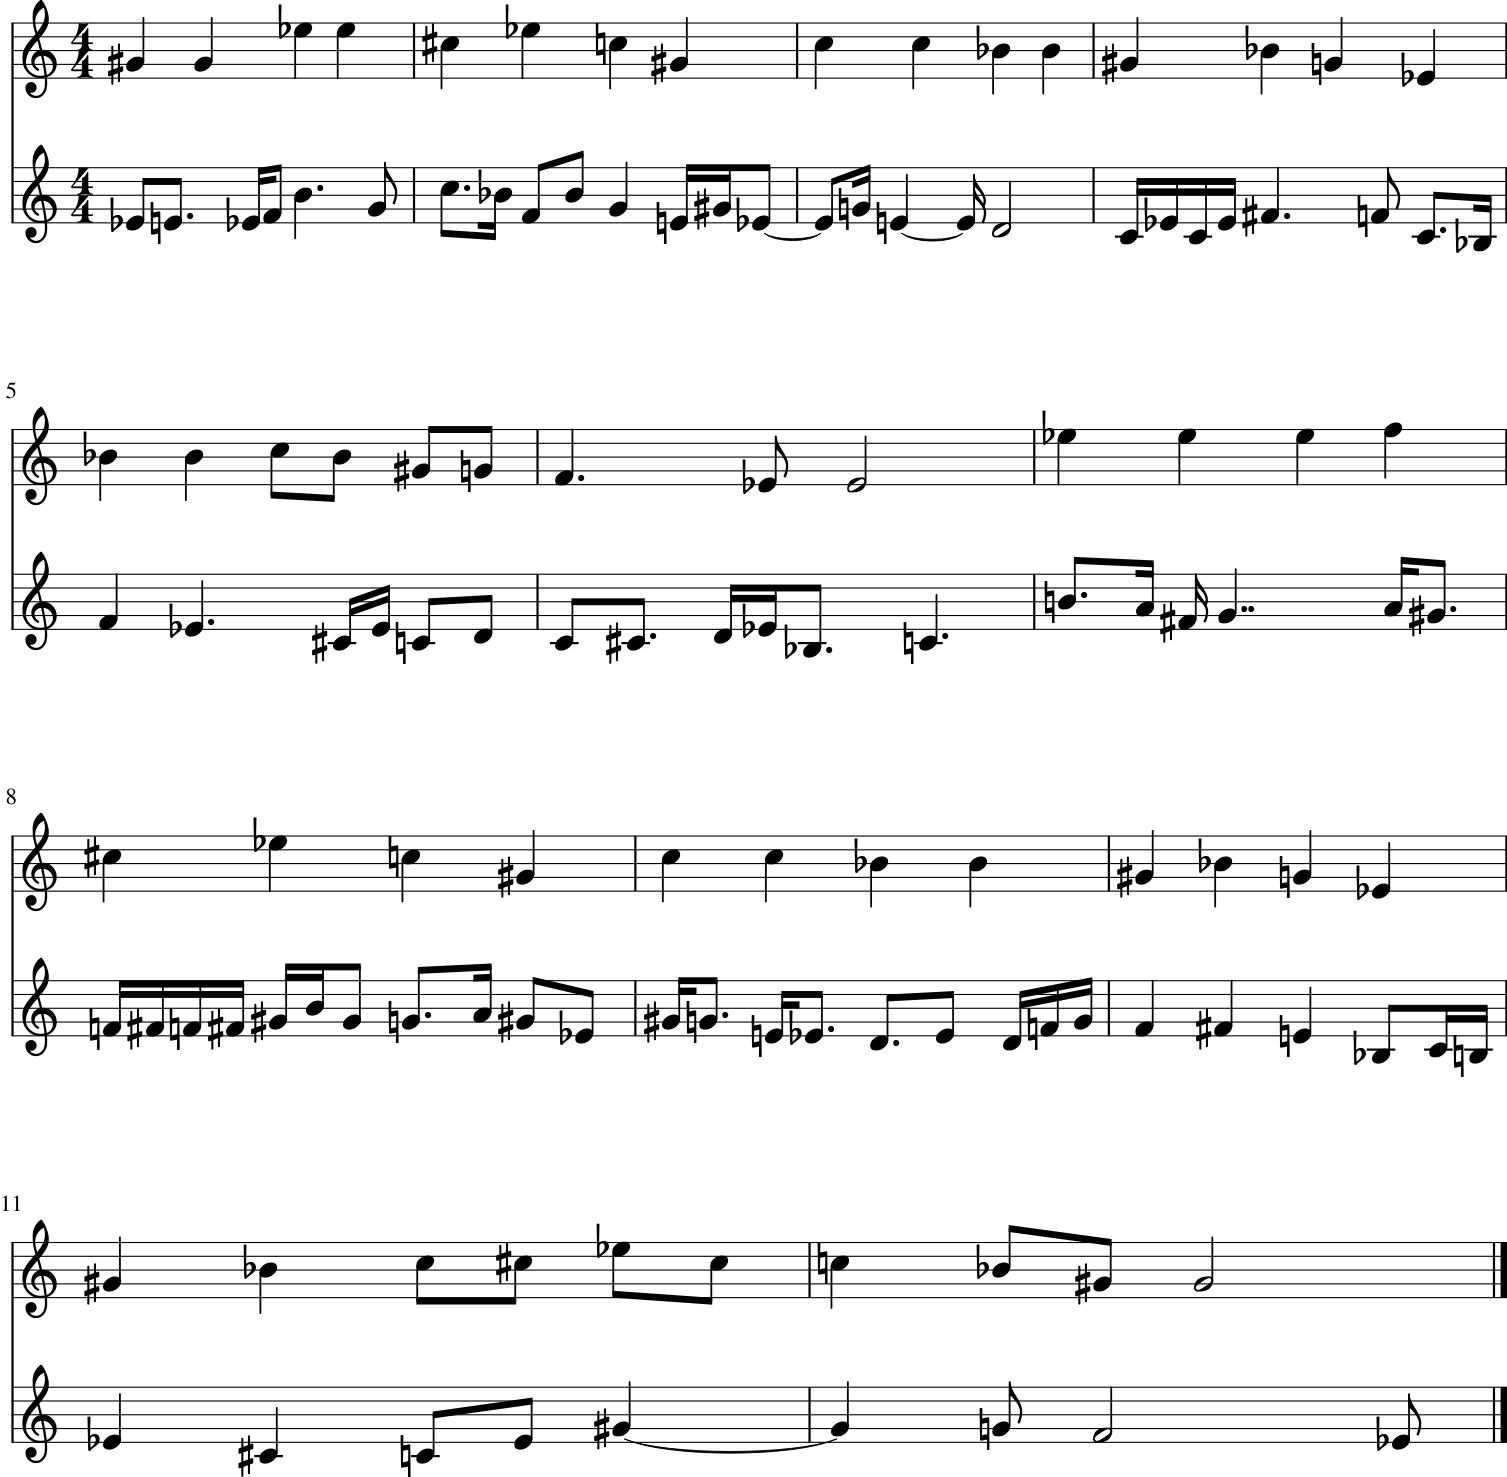

In [86]:
from music21 import midi
def export_dataset(inSongs, prediction, num_voices = 2, smooth_probability = 1):
    predSongs = []
    print(len(inSongs))
    print(len(prediction))
    for i in range(0, min(len(inSongs), len(prediction))):
        song = []
        currentTime = 0.
        melody = inSongs[i]
        voices = prediction[i]
        predPitches = [0] * (num_voices - 1)
        predMelody = 0
        for tickNum in range(min(len(melody), len(voices))):
            voice = 0
            predPitch = predPitches[voice]
            newPitch = np.argmax(voices[tickNum])
            # if old pitch still has high probability, prefer to continue note
            if (voices[tickNum, predPitch] > smooth_probability):
                pitch = predPitch
            else: pitch = newPitch
            print("pred %d / %2.2f  new %d / %2.2f -> %d" % \
                  (predPitch, voices[tickNum, predPitch], newPitch, voices[tickNum, newPitch], pitch))
                
            # smooth the melody, continue pith, if probability is still high
            attack = 1
            if (predMelody - predPitch == melody[tickNum][1] - pitch):
                attack = 0
            tick = [currentTime, melody[tickNum][1], melody[tickNum][2], pitch, attack]
            predPitches[voice] = pitch
            predMelody = melody[tickNum][1]
            #print(tick)
            song.append(tick)
            currentTime += time_tick
        predSongs.append(song)
    return predSongs

#print(songs[1])
#songNum = 0

predSongs = export_dataset(songs, prediction)
sc = createStream(predSongs[songNum], 2)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')

98
98
pred 0 / 0.00  new 6 / 0.50 -> 6
pred 6 / 0.17  new 5 / 0.40 -> 5
pred 5 / 0.21  new 8 / 0.24 -> 8
pred 8 / 0.08  new 6 / 0.35 -> 6
pred 6 / 0.67  new 6 / 0.67 -> 6
pred 6 / 0.70  new 6 / 0.70 -> 6
pred 6 / 0.12  new 4 / 0.34 -> 4
pred 4 / 0.47  new 4 / 0.47 -> 4
pred 4 / 0.04  new 9 / 0.47 -> 9
pred 9 / 0.57  new 9 / 0.57 -> 9
pred 9 / 0.16  new 3 / 0.40 -> 3
pred 3 / 0.35  new 3 / 0.35 -> 3
pred 3 / 0.00  new 4 / 0.96 -> 4
pred 4 / 0.97  new 4 / 0.97 -> 4
pred 4 / 0.94  new 4 / 0.94 -> 4
pred 4 / 0.95  new 4 / 0.95 -> 4
pred 4 / 0.00  new 9 / 0.98 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.99  new 9 / 0.99 -> 9
pred 9 / 0.00  new 10 / 0.99 -> 10
pred 10 / 0.97  new 10 / 0.97 -> 10
pred 10 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 

pred 8 / 0.96  new 8 / 0.96 -> 8
pred 8 / 0.94  new 8 / 0.94 -> 8
pred 8 / 0.98  new 8 / 0.98 -> 8
pred 8 / 0.98  new 8 / 0.98 -> 8
pred 8 / 0.00  new 10 / 0.99 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 

pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 11 / 0.99 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 

pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 0.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 7 / 1.00 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 

pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 0.99  new 7 / 0.99 -> 7
pred 7 / 0.99  new 7 / 0.99 -> 7
pred 7 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 10 / 0.99 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 13 / 1.00 -> 13
pred 13 / 0.98  new 13 / 0.98 -> 13
pred 13 / 0.00  new 12 / 1.00 -> 12
pred 12 / 1.00  new 12 / 1.00 -> 12
pred 12 / 0.01  new 10 / 0.98 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 

pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pr

pred 8 / 0.00  new 10 / 0.99 -> 10
pred 10 / 0.00  new 11 / 0.97 -> 11
pred 11 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 0.98  new 4 / 0.98 -> 4
pred 4 / 0.00  new 3 / 0.95 -> 3
pred 3 / 0.98  new 3 / 0.98 -> 3
pred 3 / 0.01  new 1 / 0.98 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.99  new 1 / 0.99 -> 1
pred 1 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.99  new 3 / 0.99 -> 3
pred 3 / 0.95  new 3 / 0.95 -> 3
pred

pred 7 / 0.99  new 7 / 0.99 -> 7
pred 7 / 0.01  new 9 / 0.98 -> 9
pred 9 / 0.99  new 9 / 0.99 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.94  new 6 / 0.94 -> 6
pred 6 / 0.01  new 8 / 0.98 -> 8
pred 8 / 0.98  new 8 / 0.98 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.01  new 7 / 0.98 -> 7
pred 7 / 0.91  new 7 / 0.91 -> 7
pred 7 / 0.00  new 5 / 0.99 -> 5
pred 5 / 1

pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 0.98  new 5 / 0.98 -> 5
pred 5 / 0.00  new 8 / 0.98 -> 8
pred 8 / 0.98  new 8 / 0.98 -> 8
pred 8 / 0.97  new 8 / 0.97 -> 8
pred 8 / 0.97  new 8 / 0.97 -> 8
pred 8 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 2 / 1.00 -> 2
pred 2 / 1.00  new 2 / 1.00 -> 2
pred 2 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 

pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 2 / 1.00 -> 2
pred 2 / 1.00  new 2 / 1.00 -> 2
pred 2 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1

pred 3 / 0.72  new 3 / 0.72 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 0.97  new 4 / 0.97 -> 4
pred 4 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1

pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.02  new 8 / 0.98 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.98  new 6 / 0.98 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 10 / 0.98 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred

pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 0.98  new 7 / 0.98 -> 7
pred 7 / 0.00  new 10 / 0.97 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.98  new 10 / 0.98 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.85  new 10 / 0.85 -> 10
pred 10 / 0.90  new 10 / 0.90 -> 10
pred 10 / 0.88  new 10 / 0.88 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.00  new 11 / 0.95 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 0.97  new 11 / 0.97 -> 11
pred 11 / 0.60  new 11 / 0.60 -> 11
pred 11 / 0.00  new 10 / 0.95 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.02  new 8 / 0.98 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 1 / 0.81 -> 1
pred 1 / 0.91  new 1 / 0.91 -> 1
pred 1 / 0.01  new 4 / 0.99 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.24  new 8 / 0.73 -> 8
pred 8 / 0.87  new 8 / 0.87 -> 8
p

pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 13 / 1.00 -> 13
pred 13 / 0.99  new 13 / 0.99 -> 13
pred 13 / 0.01  new 11 / 0.99 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 0.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.00  new 2 / 0.99 -> 2
pred 2 / 0.98  new 2 / 0.98 -> 2
pred 2 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.99  new 3 / 0.99 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.99  new 4 

pred 9 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.99  new 8 / 0.99 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 0 / 0.00  new 6 / 0.50 -> 6
pred 6 / 0.13  new 5 / 0.47 -> 6
pred 6 / 0.19  new 5 / 0.40 -> 6
pred 6 / 0.22  new 5 / 0.43 -> 6
pred 6 / 0.27  new 4 / 0.70 -> 6
pred 6 / 0.31  new 4 / 0.69 -> 6
pred 6 / 0.35  new 4 / 0.62 -> 6
pred 6 / 0.32  new 4 / 0.67 -> 6
pred 6 / 0.38  new 4 / 0.61 -> 6
pred 6 / 0.26  new 4 / 0.73 -> 6
pred 6 / 0.33  new 4 / 0.65 -> 6
pred 6 / 0.30  new 4 / 0.69 -> 6
pred 6 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred

pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 0 / 0.00  new 6 / 0.50 -> 6
pred 6 / 0.28  new 6 / 0.28 -> 6
pred 6 / 0.30  new 6 / 0.30 -> 6
pred 6 / 0.24  new 8 / 0.33 -> 6
pred 6 / 0.71  new 6 / 0.71 -> 6
pred 6 / 0.81  new 6 / 0.81 -> 6
pred 6 / 0.76  new 6 / 0.76 -> 6
pred 6 / 0.71  new 6 / 0.71 -> 6
pred 6 / 0.01  new 9 / 0.56 -> 9
pred 9 / 0.92  new 9 / 0.92 -> 9
pred 9 / 0.00  new 8 / 0.90 -> 8
pred 8 / 0.89  new 8 / 0.89 -> 8
pred 8 / 0.05  new 6 / 0.95 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.98  new 6 / 0.98 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.01  new 11 / 0.99 -> 11
pred 11 / 0.99  new 11 / 0.99 -> 11
pred 

pred 8 / 0.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 0.98  new 13 / 0.98 -> 13
pred 13 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 8 / 0.99 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.01  new 7 / 0.99 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 0.01  new 10 / 0.99 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 6 / 1.00 

pred 6 / 0.40  new 4 / 0.50 -> 6
pred 6 / 0.23  new 4 / 0.66 -> 6
pred 6 / 0.34  new 4 / 0.58 -> 6
pred 6 / 0.30  new 4 / 0.69 -> 6
pred 6 / 0.39  new 4 / 0.60 -> 6
pred 6 / 0.36  new 4 / 0.63 -> 6
pred 6 / 0.39  new 4 / 0.60 -> 6
pred 6 / 0.01  new 3 / 0.83 -> 3
pred 3 / 0.72  new 3 / 0.72 -> 3
pred 3 / 0.69  new 3 / 0.69 -> 3
pred 3 / 0.60  new 3 / 0.60 -> 3
pred 3 / 0.00  new 4 / 0.80 -> 4
pred 4 / 0.82  new 4 / 0.82 -> 4
pred 4 / 0.89  new 4 / 0.89 -> 4
pred 4 / 0.84  new 4 / 0.84 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.99  new 4 / 0.99 -> 4
pred 4 / 0.96  new 4 / 0.96 -> 4
pred 4 / 0.01  new 6 / 0.98 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.01  new 10 / 0.99 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.01  new 8 / 0.98 -> 8
pred 8 / 0.00  new 7 / 0.99 -> 7
pred 7 / 0.00  new 9 / 0.99 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred

pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 0.00  new 12 / 1.00 -> 12
pred 12 / 1.00  new 12 / 1.00 -> 12
pred 12 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
p

pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.02  new 3 / 0.98 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 1.00  new 0 / 1.00 -> 0
pred 0 / 0.00  new 5 / 1.00 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 1

pred 2 / 1.00  new 2 / 1.00 -> 2
pred 2 / 0.00  new 4 / 0.99 -> 4
pred 4 / 0.01  new 6 / 0.99 -> 6
pred 6 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.01  new 5 / 0.99 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.99  new 5 / 0.99 -> 5
pred 5 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.99  new 10 / 0.99 -> 10
pred 10 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.99  new 

pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 8 / 0.99 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.01  new 4 / 0.97 -> 4
pred 4 / 0.01  new 6 / 0.99 -> 6
pred 6 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1

pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 1.00  new 1 / 1.00 -> 1
pred 1 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 7 / 1.00 -> 7
pred 7 / 1.00  new 7 / 1.00 -> 7
pred 7 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 11 / 1.00 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 1.00  new 11 / 1.00 -> 11
pred 11 / 0.98  new 11 / 0.98 -> 11
pred 11 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 -> 13
pred 13 / 1.00  new 13 / 1.00 ->

pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.01  new 4 / 0.99 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 0.99 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0

pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 1.00  new 9 / 1.00 -> 9
pred 9 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 1.00  new 8 / 1.00 -> 8
pred 8 / 0.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 1.00  new 10 / 1.00 -> 10
pred 10 / 0.00  new 

pred 5 / 0.72  new 5 / 0.72 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.03  new 6 / 0.97 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 0.99  new 6 / 0.99 -> 6
pred 6 / 0.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 1.00  new 5 / 1.00 -> 5
pred 5 / 0.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 1.00  new 3 / 1.00 -> 3
pred 3 / 0.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 1.00  new 4 / 1.00 -> 4
pred 4 / 0.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 6 / 1.00  new 6 / 1.00 -> 6
pred 0 / 0

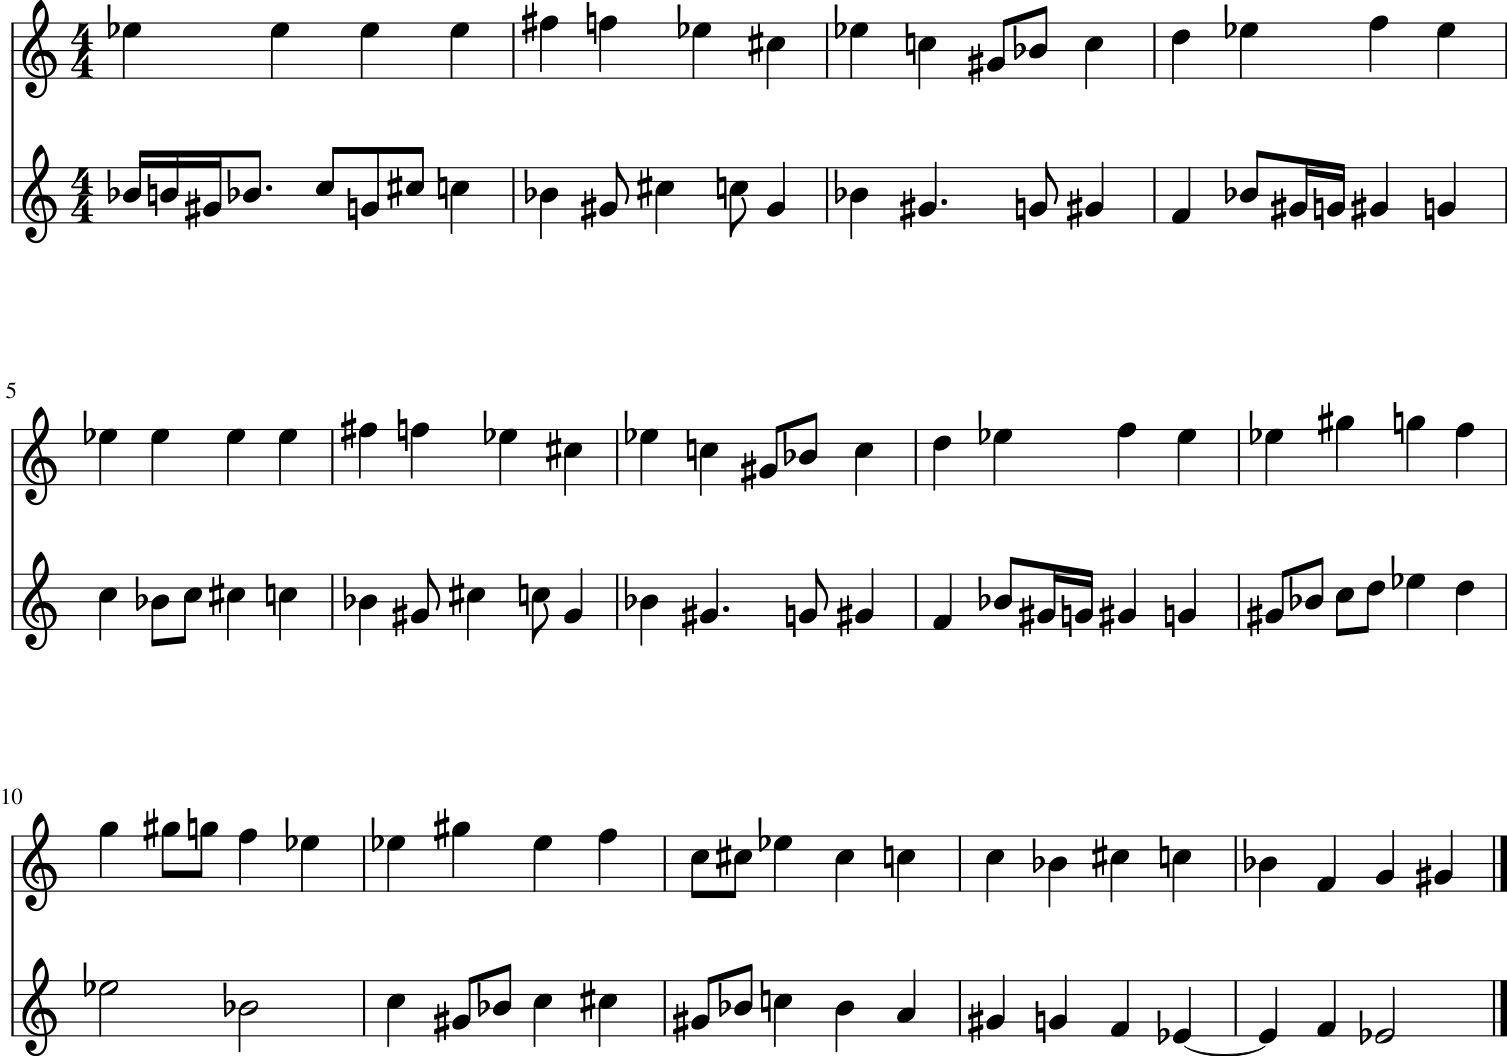

In [103]:
predSongs = export_dataset(songs, prediction)
predSongsSmooth = export_dataset(songs, prediction, smooth_probability = 0.1)
sc = createStream(predSongs[0], 2)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')
mf = midi.translate.streamToMidiFile(sc)
mf.open('/home/lucky/midi.mid', 'wb')
mf.write()
mf.close()

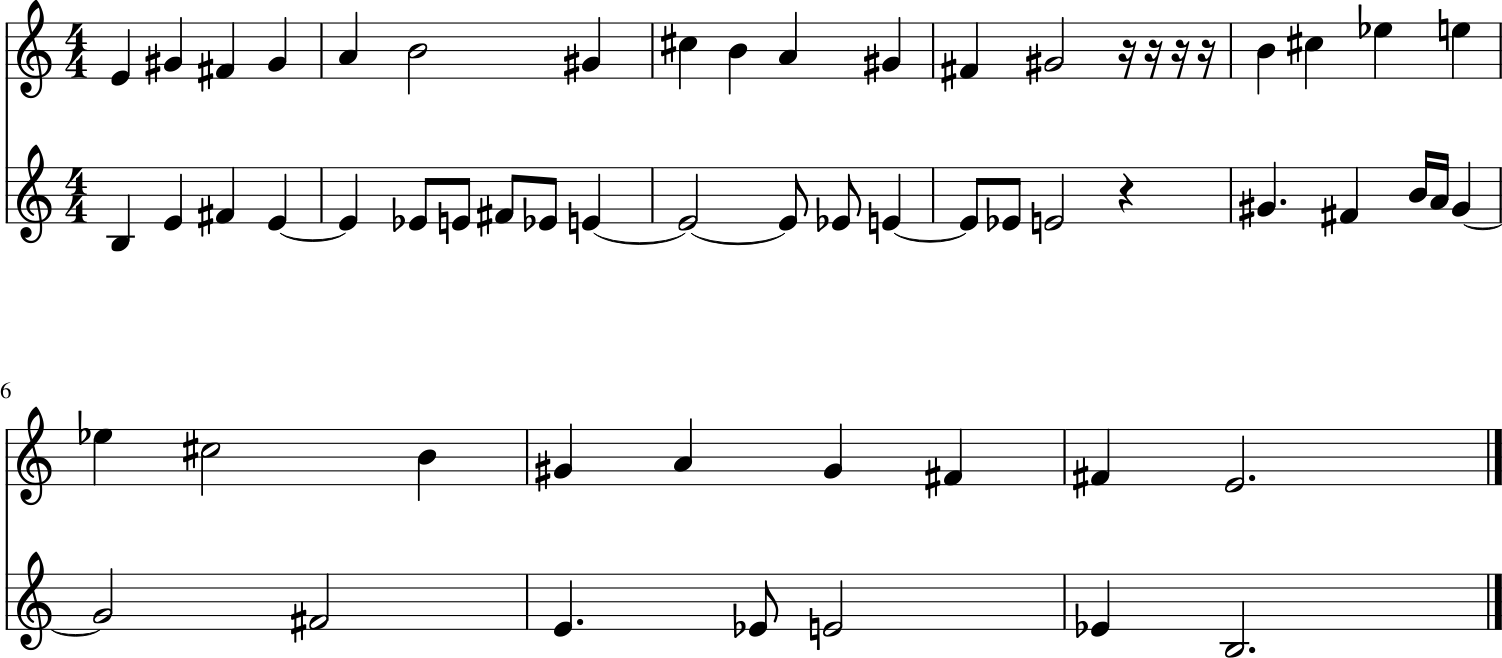

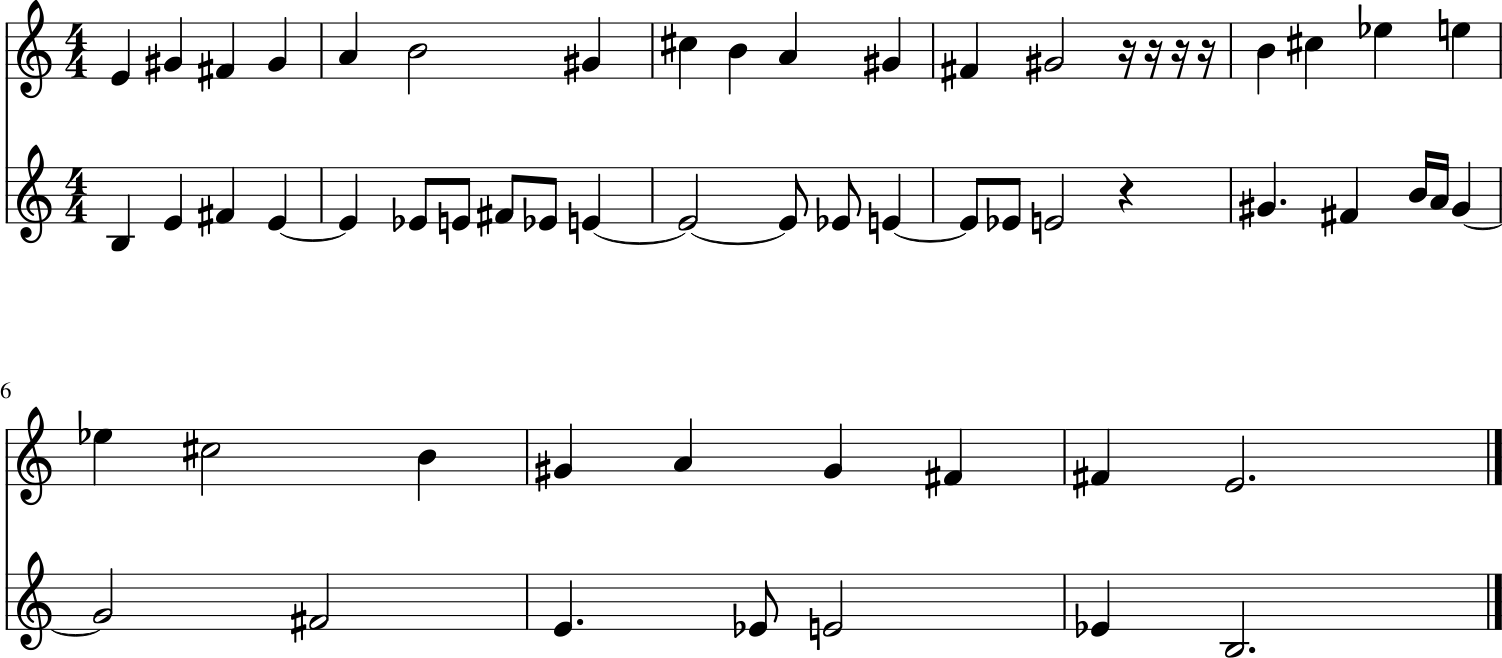

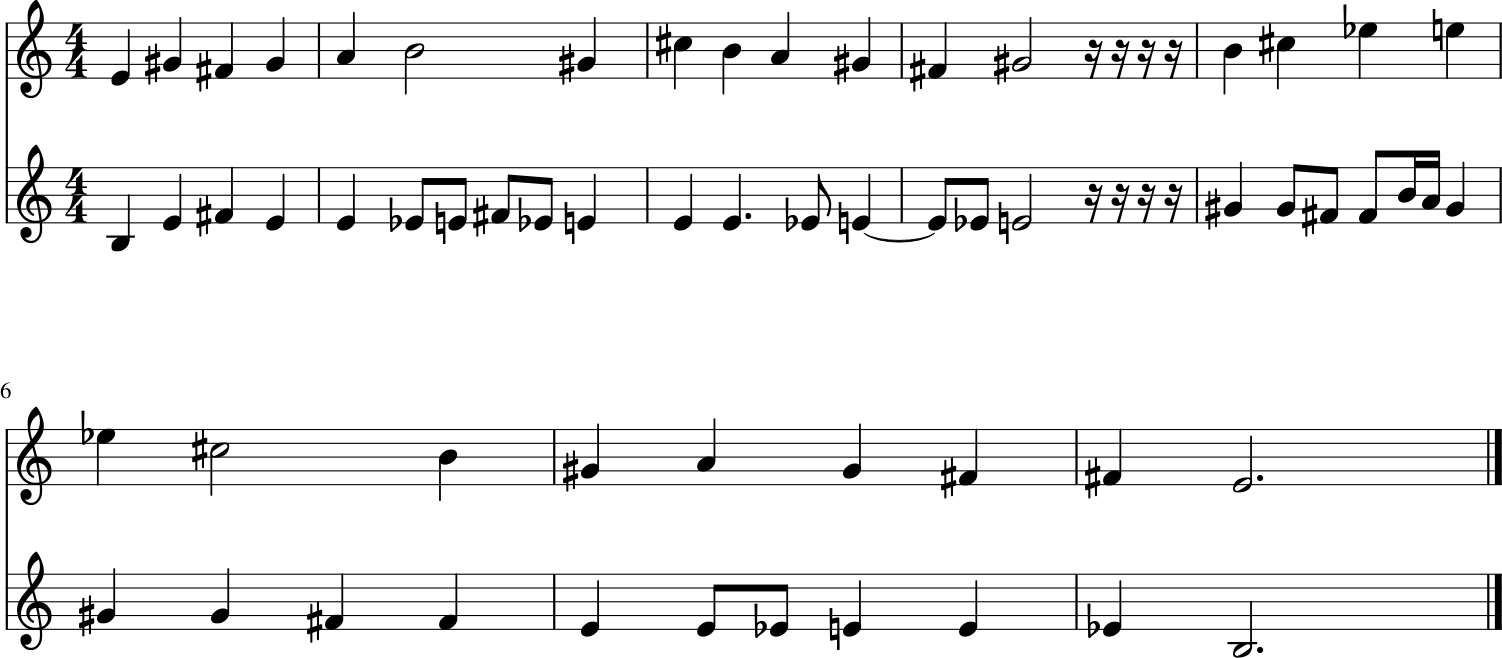

In [105]:
songNum = 1
sc = createStream(predSongs[songNum], 2)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')

sc = createStream(predSongsSmooth[songNum], 2)
#print(sc.analyze('key'))
#sc.transpose(sc.analyze('key').sharps, inPlace = True)
sc.show()
sc.show('midi')


sc = createStream(songs[songNum], 2)
sc.show()
sc.show('midi')



In [16]:
all_saver = tf.train.Saver()
all_saver.save(sess, '/home/lucky/models/98songs2voice4_4Peep')

'/home/lucky/models/98songs2voice4_4Peep'

In [26]:
print(len(songs))

98
